<div style="background-color: blue; padding: 10px; color: white;">
<h2>1. Import Necessary Libraries and Packages
</div>


In [1]:
! pip install xgboost

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, \
                            make_scorer, \
                            accuracy_score,precision_score, recall_score, f1_score, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import kendalltau, spearmanr
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# set random state
np.random.seed(42)

### This is how we will keep a running comparison of all the models and their various tuned counterparts: 

In [3]:
# dataframe for scores amongst models
master_scores = pd.DataFrame(columns=['Model','Recall', 'F1', 'Precision', 'Accuracy'])

In [4]:
# add_to_master(model_description, y_true, y_predicted, binary=True)
def add_to_master(model_description, y_test, y_pred, binary=True):
    '''
    Adds a new row to the running score DataFrame `master_scores` 
    and functions for adding both binary and multiclass scores. 
    '''
    global master_scores
    if binary == True:
        # Evalution Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,2), 
            'F1': round(f1, 2), 
            'Precision': round(precision, 2), 
            'Accuracy': round(accuracy, 2)}
        
        master_scores = master_scores.append(new_row, ignore_index=True)   
    
    else:
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro') # I chose macro since we have less of the sucklers 
        recall = recall_score(y_test, y_pred, average='macro')       # and I want their accuracy to be meaningful
        f1 = f1_score(y_test, y_pred, average='macro')


        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,2), 
            'F1': round(f1, 2), 
            'Precision': round(precision, 2), 
            'Accuracy': round(accuracy, 2)}
        master_scores = master_scores.append(new_row, ignore_index=True)
    return master_scores

<div style="background-color: blue; padding: 10px; color: white;">
<h2>2. Read in Data
</div>


In [5]:
df = pd.read_csv('../Data/cat_clean.csv')
df

,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
0,4.0274,2,1,BEN,8,0,1,4,5,1,1,1,2,1,1.0,0.0,1.0
1,2.1096,2,1,BEN,8,0,1,5,4,1,1,1,3,3,1.0,0.0,1.0
2,7.6822,1,1,BUR,4,0,1,4,5,1,1,1,2,1,4.0,3.0,2.0
3,5.0027,1,1,BUR,4,4,0,5,5,1,1,2,1,1,1.0,0.0,1.0
4,5.0137,1,1,EUR,4,5,1,4,5,1,1,1,2,1,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,11.1151,1,1,NFO,4,3,1,3,5,1,1,1,1,1,1.0,4.0,2.0
5692,6.3644,1,0,NFO,4,5,1,4,3,1,1,1,2,2,1.0,0.0,1.0
5693,3.1205,1,1,NFO,4,4,1,4,5,1,1,1,2,1,3.0,0.0,1.0
5694,3.6274,1,1,NFO,5,1,1,5,3,1,1,1,4,3,2.0,4.0,1.0


<div style="background-color: blue; padding: 10px; color: white;">
<h2>3. Explore Data
</div>


In [6]:
df.describe()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
count,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000
mean,4.752602,1.539326,0.779670,4.619031,2.547753,0.847788,3.770190,4.088834,1.116397,1.096559,1.583743,2.025632,1.884480,1.789150,0.912395,1.070400
std,3.768478,0.498495,0.414506,1.576234,1.911887,0.359258,0.864699,0.878686,0.418163,0.368394,0.839547,0.996769,1.051775,0.997606,1.544499,0.384687
min,0.167100,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.789000,1.000000,1.000000,4.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,3.886300,2.000000,1.000000,4.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,6.778100,2.000000,1.000000,5.000000,5.000000,1.000000,4.000000,5.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1.000000
max,24.811000,2.000000,1.000000,8.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7.000000,3.000000


###  3.1 Target Feature Class Distribution
I forget what the class distribution of my target feature `Wool_sucking` look like. A relatively balanced distribution is really important for most algorithms.  

In [7]:
df['Wool_sucking'].value_counts()

0.0    3891
4.0     421
2.0     403
3.0     378
1.0     368
5.0     207
6.0      26
7.0       2
Name: Wool_sucking, dtype: int64

Wow! Quite imbalanced. I think since my dataset is rather small and I have very little sucking kitties compared to non-suckers, I will do binary classification. Multiclass algorithms tend to do best when each class has at least 100 samples (defintely not 26 or 2!). Plus, it will still fulfill the goal: Identify what cats are going to do this really cute thing. 

In [8]:
# assign 1-7 as suckers (1)
df_bin = df.copy()
df_bin['ws_binary'] = df_bin['Wool_sucking'].replace([1, 2, 3, 4, 5, 6, 7], [1, 1, 1, 1, 1, 1, 1])
df_bin.drop(columns='Wool_sucking')
df_bin['ws_binary'].value_counts()

0.0    3891
1.0    1805
Name: ws_binary, dtype: int64

### Behavior Problem Recode

In [9]:
df_bin.Behaviour_problem.value_counts()

1.0    5035
2.0     426
0.0     165
3.0      70
Name: Behaviour_problem, dtype: int64

Similarly, `Behaviour_problem` has quite the imbalance and, upon further inspection, the original scores are "Does your cat have a behavior problem? 0=I don't know, 1=no, 2=yes, self-diagnosed, 3=yes, diagnosed by a veterinarian." So, I'm going to binarize this as a simple yes/no because class 3 is not going to perform well in modelling. 

In [10]:
# Recode Behaviour_problem to binary
df_bin['Behaviour_problem'].replace([1, 2, 3], [0, 1, 1], inplace=True)
df_bin['Behaviour_problem'].value_counts()

0.0    5200
1.0     496
Name: Behaviour_problem, dtype: int64

<div style="background-color: blue; padding: 10px; color: white;">
<h2>4. Create Training/Test Data</h2>
</div>


In [11]:
# how many breed groups are there?
len(df_bin['Breed_group'].value_counts())

19

In [12]:
# most algorithms can't handle nominal variables, so let's one-hot encode those guys! 
df_bin_encoded = pd.concat([pd.get_dummies(df_bin['Breed_group'], prefix="BG"), df_bin], axis=1).drop(columns='Breed_group')
df_bin_encoded.head()

,BG_ABY,BG_BEN,BG_BRI,BG_BUR,BG_CRX,BG_DRX,BG_EUR,BG_HCS,BG_KOR,BG_MCO,...,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem,ws_binary
0,0,1,0,0,0,0,0,0,0,0,...,5,1,1,1,2,1,1.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,4,1,1,1,3,3,1.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,5,1,1,1,2,1,4.0,3.0,1.0,1.0
3,0,0,0,1,0,0,0,0,0,0,...,5,1,1,2,1,1,1.0,0.0,0.0,0.0
4,0,0,0,0,0,0,1,0,0,0,...,5,1,1,1,2,1,1.0,0.0,0.0,0.0


In [13]:
X = df_bin_encoded.drop(columns=["ws_binary", "Wool_sucking"])
y = df_bin_encoded["ws_binary"]

In [14]:
# I still have some serious class imablance for my wool-suckers, hence stratify to maintain that imbalance for train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

<div style="background-color: blue; padding: 10px; color: white;">
<h2>5. Checking for Multicollinearity</h2>
<p>Note: Any preprocessing or EDA for feature engineering purposes should always be done on training set because we should operate like the test set has NEVER been seen. This minimizes risk of data leakage and therefore increases chance of generalizability. Most of the models I will be using can handle multicollinearity, but I would like to see what we're working with anyway. </p>
</div>

In [15]:
# organizing by variable type
continuous_variable = X_train['Age']
breed_groups = X_train.iloc[:, :19]
dichotomous_variables = pd.concat([X_train[['Gender', 'Neuter_status', 'Other_cats', 'Behaviour_problem']], breed_groups],
                                  axis=1)
ordinal_variables = X_train[['Weaning_age', 'Outdoors', 'Activity_level', 
                             'Contact_people', 'Aggression_stranger', 'Aggression_owner', 'Aggression_cats',
                            'Shyness_novel', 'Shyness_strangers', 'Grooming']]

I opted to employ Kendall's tau as the correlation measure due to its specific suitability for capturing the relationships between ordinal pairs. By focusing on the direction of the pairwise relationships rather than the magnitude, Kendall's tau can account for the varying magnitudes observed in these Likert-like scales, ensuring a more robust assessment of the ordinal associations within the data.

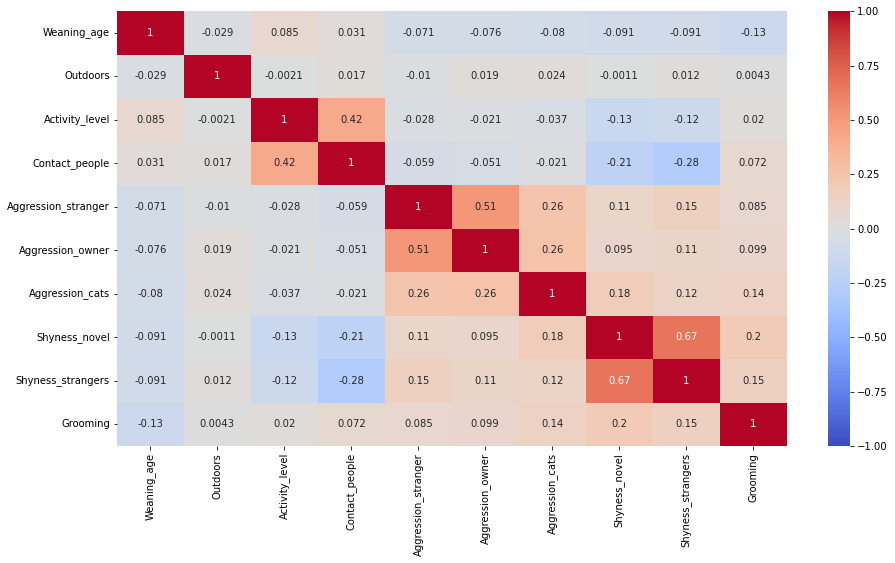

In [16]:
# Kendall's Tau for Correlation Between Ordinal Variables
kendall_corr = ordinal_variables.corr(method='kendall')
plt.figure(figsize=(15, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

I figured the aggression with people (stranger or owner) would be correlated. Likewise for the two shyness features. I don't think I will need to do any feature selection/extraction here since I think the model that would work best for this dataset all handle multicollinearity quite well. If necessary, I think a simple average of the two people aggression features to create a new feature Aggression_people and dropping the parents could be a good solution. Likewise with the shyness features. 

Point biserial correlation is used when you have one continuous variable and one dichotomous variable. Biserial correlation is used when you have two continuous variables, but one of them is artificially dichotomized. As the latter condition is not accurate here I will be using the former metric. 

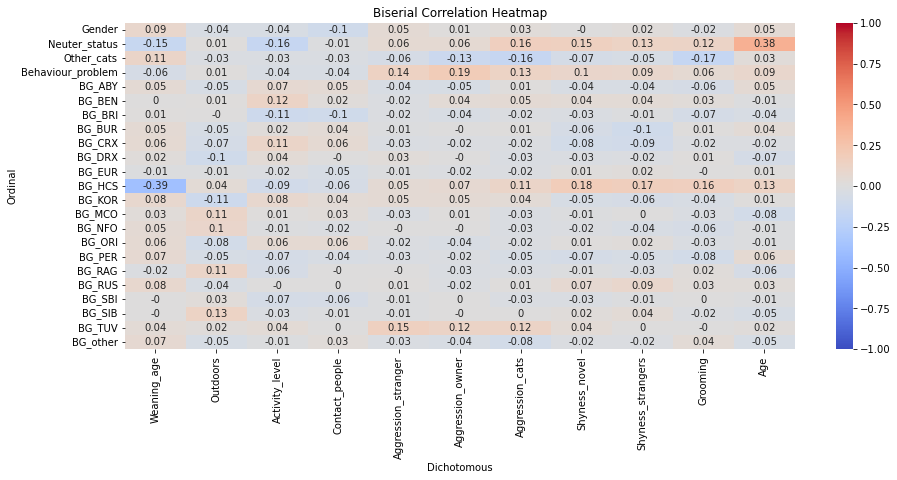

In [17]:
# Biserial Correlation Coefficient for dichXordinal if we treat ordinal_variables as continuous
biserial = pd.concat([dichotomous_variables, ordinal_variables, continuous_variable], axis=1)
correlation_matrix = pd.DataFrame(index=biserial.columns, columns=biserial.columns)
for i, column_i in enumerate(biserial.columns):
    for j, column_j in enumerate(biserial.columns):
        if i != j:
            corr, p_value = stats.pointbiserialr(biserial[column_i], biserial[column_j])
            correlation_matrix.at[column_i, column_j] = round(corr, 2)
heatmap_matrix = correlation_matrix.iloc[:23,23:] #drops anything not dich on "continuous"
plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Biserial Correlation Heatmap')
plt.xlabel('Dichotomous')
plt.ylabel('Ordinal');

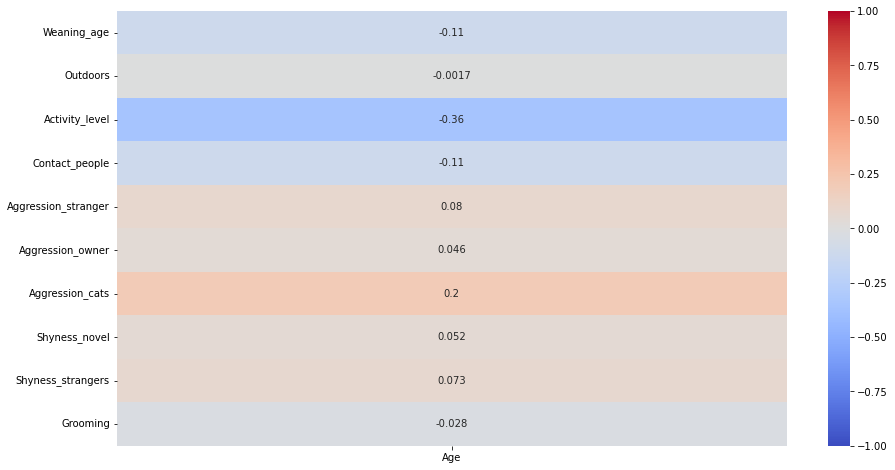

In [18]:
# Spearman's rho for contXordinal
spearman = pd.concat([continuous_variable, ordinal_variables], axis=1)

spearman_matrix = spearman.corr(method='spearman')

spearman_matrix = spearman_matrix.iloc[1:, [0]]

plt.figure(figsize=(15, 8))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

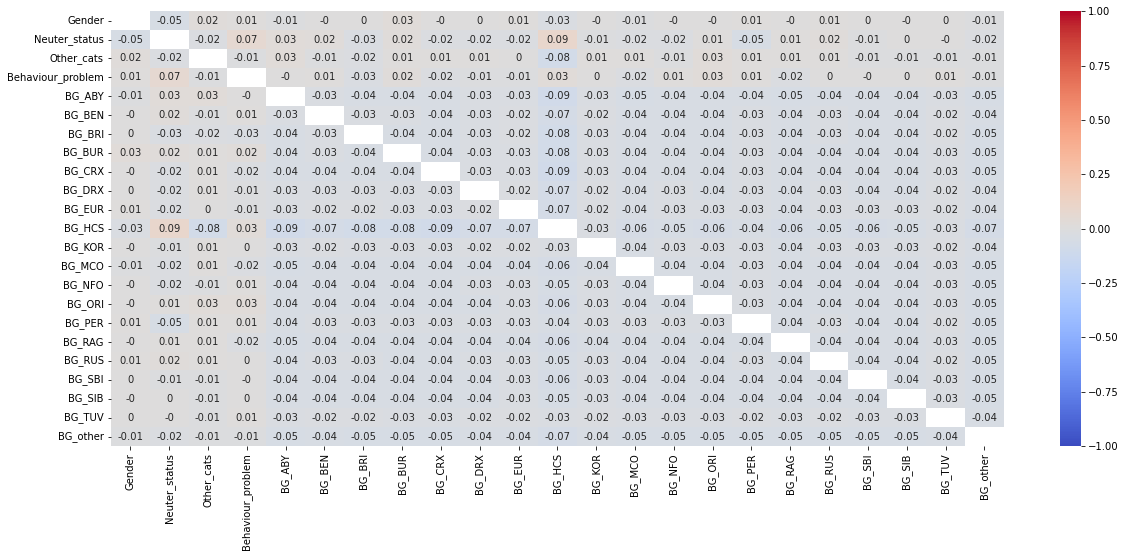

In [19]:
# phi coefficient for dichXdich
# Create an empty correlation matrix
dichotomous_columns = dichotomous_variables.columns
correlation_matrix = pd.DataFrame(index=dichotomous_columns, columns=dichotomous_columns)

# Calculate phi coefficient for each pair of columns
for i in range(len(dichotomous_columns)):
    for j in range(i+1, len(dichotomous_columns)):
        column1 = dichotomous_variables[dichotomous_columns[i]]
        column2 = dichotomous_variables[dichotomous_columns[j]]
        contingency_table = pd.crosstab(column1, column2)
        n = np.sum(contingency_table.values)
        n11 = contingency_table.iloc[1, 1]
        n10 = contingency_table.iloc[1, 0]
        n01 = contingency_table.iloc[0, 1]
        n00 = contingency_table.iloc[0, 0]
        phi = round((n11 * n00 - n10 * n01) / np.sqrt((n10 + n11) * (n00 + n01) * (n10 + n01) * (n00 + n11)),2)
        correlation_matrix.loc[dichotomous_columns[i], dichotomous_columns[j]] = phi
        correlation_matrix.loc[dichotomous_columns[j], dichotomous_columns[i]] = phi

# Convert the correlation matrix values to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

That's about as comprehensive and into the weeds as I'm willing to get. It looks like the only real concerns are those shyness traits and the aggression (towards people) traits. The models I'm going to be using are typically resistant to multicollinearity, and they don't seem to be *very* strongly correlated, but I want my coefficients to be interpretable, so I am going to go ahead and replace those four columns with their two aggregate counterparts. 

## Addressing Multicollinearity

In [20]:
# making agg columns for training set 
X_train['agg_shy'] = (X_train['Shyness_novel'] + X_train['Shyness_strangers']) / 2
X_train['agg_aggress_people'] = (X_train['Aggression_owner'] + X_train['Aggression_stranger']) / 2 
X_train.drop(columns=['Shyness_novel', 'Shyness_strangers', 'Aggression_stranger', 'Aggression_owner'], inplace=True)
X_train.columns

Index(['BG_ABY', 'BG_BEN', 'BG_BRI', 'BG_BUR', 'BG_CRX', 'BG_DRX', 'BG_EUR',
       'BG_HCS', 'BG_KOR', 'BG_MCO', 'BG_NFO', 'BG_ORI', 'BG_PER', 'BG_RAG',
       'BG_RUS', 'BG_SBI', 'BG_SIB', 'BG_TUV', 'BG_other', 'Age', 'Gender',
       'Neuter_status', 'Weaning_age', 'Outdoors', 'Other_cats',
       'Activity_level', 'Contact_people', 'Aggression_cats', 'Grooming',
       'Behaviour_problem', 'agg_shy', 'agg_aggress_people'],
      dtype='object')

In [21]:
# making agg columns for testing set
X_test['agg_shy'] = (X_test['Shyness_novel'] + X_test['Shyness_strangers']) / 2
X_test['agg_aggress_people'] = (X_test['Aggression_owner'] + X_test['Aggression_stranger']) / 2
X_test.drop(columns=['Shyness_novel', 'Shyness_strangers', 'Aggression_stranger', 'Aggression_owner'], inplace=True)
X_test.columns

Index(['BG_ABY', 'BG_BEN', 'BG_BRI', 'BG_BUR', 'BG_CRX', 'BG_DRX', 'BG_EUR',
       'BG_HCS', 'BG_KOR', 'BG_MCO', 'BG_NFO', 'BG_ORI', 'BG_PER', 'BG_RAG',
       'BG_RUS', 'BG_SBI', 'BG_SIB', 'BG_TUV', 'BG_other', 'Age', 'Gender',
       'Neuter_status', 'Weaning_age', 'Outdoors', 'Other_cats',
       'Activity_level', 'Contact_people', 'Aggression_cats', 'Grooming',
       'Behaviour_problem', 'agg_shy', 'agg_aggress_people'],
      dtype='object')

<div style="background-color: blue; padding: 10px; color: white;">
<h1>6. Modelling</h1>
<p> Logistic Regression. RUS and ROS Lasso and Ridge. </p>
</div>


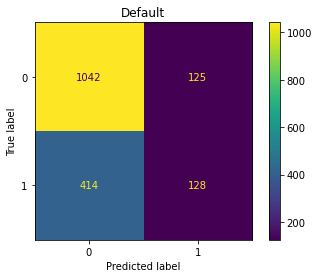

,Model,Recall,F1,Precision,Accuracy
0,Default,0.24,0.32,0.51,0.68


In [22]:
# Model 1: How does the default perform?
log_default = LogisticRegression().fit(X_train, y_train)
y_pred = log_default.predict(X_test)

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master('Default', y_test, y_pred)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('Default')
plt.show()

master_scores.sort_values('Recall', ascending=False).head()

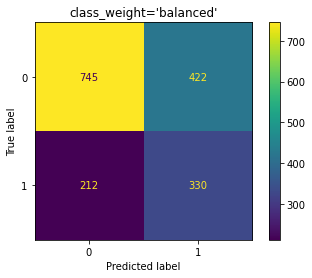

,Model,Recall,F1,Precision,Accuracy
1,class_weight='balanced',0.61,0.51,0.44,0.63
0,Default,0.24,0.32,0.51,0.68


In [23]:
# Model 2: What about with class_weight='balanced'
log_balanced = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
y_pred = log_balanced.predict(X_test)

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("class_weight='balanced'", y_test, y_pred)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title("class_weight='balanced'")
plt.show()

master_scores.sort_values('Recall', ascending=False).head()

## 6.3 Incorporating Resampling Methods to Address Class Imbalance

Still not doing too hot (but certainly better!). The model is still just predicting the majority class for most cases. I think it's time for a little resampling. I'm going to try random under sampling and random over sampling. I'm also curious to see if either Lasso or Ridge regularization would help. The regularization should address that pesk multicollinearity if it's an issue. Logistic regression's coefficients are typically pretty interpretable, but only if the underlying relationship is linear. However, regularization worsens the interpretability since Lasso will shrink some feature's coefficients to 0 (which is how it handles multicollinearity) and Ridge does not drive them to zero, but still distributes its penalty across correlated features evenly which results in less meaningful variability. 

In [24]:
rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler()
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

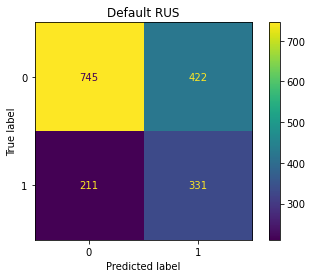

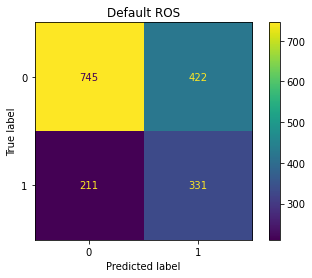

,Model,Recall,F1,Precision,Accuracy
0,Default,0.24,0.32,0.51,0.68
1,class_weight='balanced',0.61,0.51,0.44,0.63
2,Default RUS,0.61,0.51,0.44,0.63
3,Default ROS,0.61,0.51,0.44,0.63


In [25]:
# Model 3: default rus
log = LogisticRegression().fit(X_resampled_rus, y_resampled_rus)
y_pred = log.predict(X_test)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('Default RUS')
plt.show()

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("Default RUS", y_test, y_pred)

# Model 4: default ros
log = LogisticRegression().fit(X_resampled_rus, y_resampled_rus)
y_pred = log.predict(X_test)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('Default ROS')
plt.show()

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("Default ROS", y_test, y_pred)

### 6.4.1 Lasso RUS

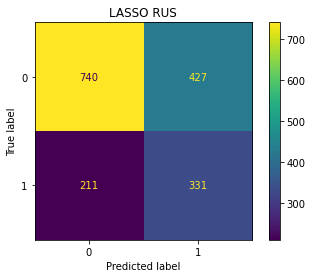

,Model,Recall,F1,Precision,Accuracy
0,Default,0.24,0.32,0.51,0.68
1,class_weight='balanced',0.61,0.51,0.44,0.63
2,Default RUS,0.61,0.51,0.44,0.63
3,Default ROS,0.61,0.51,0.44,0.63
4,LASSO RUS,0.61,0.51,0.44,0.63


In [26]:
# Model 5: RUS LASSO
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_rus)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
log = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga').fit(X_train_scaled, y_resampled_rus)

# Calculate Prediction
y_pred = log.predict(X_test_scaled)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('LASSO RUS')
plt.show()

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master("LASSO RUS", y_test, y_pred)

### 6.4.2 Lasso ROS

In [27]:
# Model 6: ROS LASSO
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_ros)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
log = LogisticRegression(penalty='l1', solver='saga').fit(X_train_scaled, y_resampled_ros)

# Calculate Prediction
y_pred = log.predict(X_test_scaled)

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master('LASSO ROS', y_test, y_pred)

,Model,Recall,F1,Precision,Accuracy
0,Default,0.24,0.32,0.51,0.68
1,class_weight='balanced',0.61,0.51,0.44,0.63
2,Default RUS,0.61,0.51,0.44,0.63
3,Default ROS,0.61,0.51,0.44,0.63
4,LASSO RUS,0.61,0.51,0.44,0.63
5,LASSO ROS,0.61,0.51,0.44,0.63


### 6.4.3 Ridge RUS

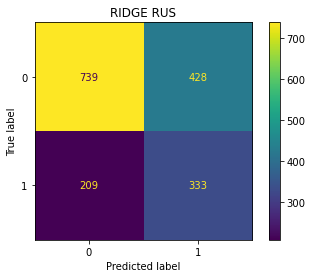

,Model,Recall,F1,Precision,Accuracy
0,Default,0.24,0.32,0.51,0.68
1,class_weight='balanced',0.61,0.51,0.44,0.63
2,Default RUS,0.61,0.51,0.44,0.63
3,Default ROS,0.61,0.51,0.44,0.63
4,LASSO RUS,0.61,0.51,0.44,0.63
5,LASSO ROS,0.61,0.51,0.44,0.63
6,RIDGE RUS,0.61,0.51,0.44,0.63


In [28]:
# Model 7: RUS RIDGE
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_rus)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
log = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200).fit(X_train_scaled, y_resampled_rus)

# Calculate Prediction
y_pred = log.predict(X_test_scaled)

cms = confusion_matrix(y_test, y_pred)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.title('RIDGE RUS')
plt.show()

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master('RIDGE RUS', y_test, y_pred)

### 6.4.1 Ridge ROS

In [29]:
# Model 8: ROS RIDGE
# scaling because we are applying regularization 
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_resampled_ros)
X_test_scaled = scaler.transform(X_test)

# Instantiate model, multinomial can only handle saga solver when penalty=l1
log = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200).fit(X_train_scaled, y_resampled_ros)

# Calculate Prediction
y_pred = log.predict(X_test_scaled)

# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master('RIDGE ROS', y_test, y_pred);

In [30]:
master_scores.sort_values('Recall', ascending=False)

,Model,Recall,F1,Precision,Accuracy
1,class_weight='balanced',0.61,0.51,0.44,0.63
2,Default RUS,0.61,0.51,0.44,0.63
3,Default ROS,0.61,0.51,0.44,0.63
4,LASSO RUS,0.61,0.51,0.44,0.63
5,LASSO ROS,0.61,0.51,0.44,0.63
6,RIDGE RUS,0.61,0.51,0.44,0.63
7,RIDGE ROS,0.6,0.51,0.44,0.63
0,Default,0.24,0.32,0.51,0.68


Surprisingly, they all performed very similarly! In interest of parsimony, we're going to move forward with the class_weight='balanced' model as it requires the least amount of prep. 

<div style="background-color: blue; padding: 10px; color: white;">
<h1>7. Digging Deeper: Post-Modeling EDA </h1>
<p> I want to know where specifically it made misclassifications, especially in pairing the original scores back up with the compressed ones. I assume most of the mistakes are in the 6 and 7 categories. </p>
</div>

### Question: What features were most important in prediction?

In [31]:
# Get the coefficients and corresponding feature names
coefficients = log_balanced.coef_[0]
feature_names = X_train.columns

# Combine coefficients with feature names into a dictionary
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort the feature coefficients by magnitude
sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)


# Print the top most predictive features
top_features = 15  # Set the number of top features to display
for i, (feature, coefficient) in enumerate(sorted_coefficients[:top_features], start=1):
    print(f"{i}: {feature} {round(coefficient,2)}")

coefficient_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

1: BG_RUS -1.11
2: BG_PER -0.66
3: Neuter_status 0.51
4: BG_TUV 0.46
5: Grooming 0.39
6: BG_ORI 0.39
7: BG_SBI 0.38
8: BG_KOR 0.37
9: BG_other -0.36
10: BG_BRI -0.33
11: BG_EUR -0.32
12: BG_BUR -0.32
13: BG_NFO 0.32
14: Behaviour_problem 0.28
15: BG_HCS 0.24


Wow! Breed really has a lot to do with wool_sucking. So does their neuter status, excessive grooming behaviors, and behavior problem status. 

### Question: When you reassociate the original class pre-binarization, which ones is it getting wrong most often?

In [32]:
y_pred = log_balanced.predict(X_test)
y_proba = log_balanced.predict_proba(X_test)
test_pred_prob = pd.DataFrame({'True': y_test, 'Predicted': y_pred, 'Prob 0': y_proba[:, 0], 'Prob 1': y_proba[:, 1]})

In [33]:
# reassociate original variable
final = test_pred_prob.join(df)
final

,True,Predicted,Prob 0,Prob 1,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,...,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
5027,0.0,1.0,0.289764,0.710236,4.3890,2,1,HCS,2,3,...,3,4,1,1,1,2,2,3.0,0.0,1.0
5588,0.0,0.0,0.507981,0.492019,2.2822,2,1,ABY,6,1,...,4,5,1,1,1,3,2,1.0,0.0,1.0
2338,0.0,1.0,0.399101,0.600899,4.6137,1,1,CRX,4,1,...,2,4,1,1,1,2,2,3.0,0.0,1.0
596,0.0,0.0,0.714151,0.285849,3.9808,2,1,RUS,4,2,...,3,3,2,1,4,4,3,1.0,0.0,1.0
3035,1.0,0.0,0.536622,0.463378,1.4192,1,0,BUR,4,1,...,4,4,1,1,2,4,2,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,0.0,1.0,0.432051,0.567949,4.6137,1,1,EUR,4,4,...,5,5,1,1,2,2,2,3.0,0.0,1.0
1619,0.0,1.0,0.470654,0.529346,3.0849,2,1,SIB,4,5,...,3,2,2,1,1,2,2,3.0,0.0,1.0
5673,0.0,1.0,0.484557,0.515443,6.1753,2,1,NFO,4,5,...,3,3,1,1,2,2,2,2.0,0.0,1.0
1792,0.0,0.0,0.759355,0.240645,3.4411,2,0,CRX,5,5,...,4,5,1,1,2,1,1,1.0,0.0,1.0


In [34]:
proportion_suckers = len(final[final['True'] == 1]) / len(final['True'])
final_model_recall = recall_score(y_test, y_pred)
percent_improvement = (final_model_recall - proportion_suckers) / proportion_suckers * 100
round(percent_improvement)

92

In [35]:
# should be 626
mismatched = final[final['Predicted'] != final['True']]
mismatched

,True,Predicted,Prob 0,Prob 1,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,...,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
5027,0.0,1.0,0.289764,0.710236,4.3890,2,1,HCS,2,3,...,3,4,1,1,1,2,2,3.0,0.0,1.0
2338,0.0,1.0,0.399101,0.600899,4.6137,1,1,CRX,4,1,...,2,4,1,1,1,2,2,3.0,0.0,1.0
3035,1.0,0.0,0.536622,0.463378,1.4192,1,0,BUR,4,1,...,4,4,1,1,2,4,2,2.0,3.0,1.0
1602,0.0,1.0,0.341096,0.658904,3.8603,2,1,CRX,4,0,...,5,5,1,1,1,1,1,3.0,0.0,1.0
2361,0.0,1.0,0.354886,0.645114,0.6438,2,1,TUV,4,5,...,4,4,1,1,1,2,2,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,0.0,1.0,0.437507,0.562493,5.0575,1,1,other,4,3,...,3,5,1,1,3,2,1,3.0,0.0,1.0
5570,0.0,1.0,0.400269,0.599731,1.0329,1,1,ABY,6,4,...,5,5,1,1,1,1,1,3.0,0.0,1.0
2209,0.0,1.0,0.432051,0.567949,4.6137,1,1,EUR,4,4,...,5,5,1,1,2,2,2,3.0,0.0,1.0
1619,0.0,1.0,0.470654,0.529346,3.0849,2,1,SIB,4,5,...,3,2,2,1,1,2,2,3.0,0.0,1.0


In [36]:
should_be_0 = mismatched[mismatched['True'] == 0]
should_be_1 = mismatched[mismatched['True'] == 1]

In [37]:
should_be_0['Wool_sucking'].value_counts()

0.0    422
Name: Wool_sucking, dtype: int64

In [38]:
should_be_1['Wool_sucking'].value_counts()

1.0    52
4.0    48
2.0    46
3.0    42
5.0    19
6.0     5
Name: Wool_sucking, dtype: int64

Interestingly, it did not misclassify any of the most of the day suckers (7's) and got more than half of the several times/day (6's) and daily (5's) right. I want to see what these more extreme cases have in common. I assume it will be breed considering those features were most predictive in the model. 

In [39]:
final['Wool_sucking'].value_counts()

0.0    1167
4.0     134
2.0     118
3.0     107
1.0     105
5.0      64
6.0      13
7.0       1
Name: Wool_sucking, dtype: int64

In [40]:
extreme_suckers = final[(final['Wool_sucking']== 7.0) 
          | (final['Wool_sucking']== 6.0) 
          | (final['Wool_sucking']== 5.0)
          | (final['Wool_sucking'] == 4.0)]
mild_suckers = final[(final['Wool_sucking']== 3.0) 
          | (final['Wool_sucking']== 2.0) 
          | (final['Wool_sucking'] == 1.0)] # wasn't sure if I wanted to include 1's, but if the cat's only 1 year old
                                            # and has wool-sucked 1-3x/lifetime, that's basically 1-12 times/year. 
non_suckers = final[(final['Wool_sucking']== 0.0)]

#### Breed Group:

In [56]:
# top predictive breed groups sorted into negative and positive predictors
breed_coeff_dict = {'Breed': [], 'Coefficient': []}
for index, row in coefficient_df.iterrows():
    if (row['Feature'].startswith('BG_')) & (abs(row['Coefficient']) > 0.2):
        breed_coeff_dict['Breed'].append(row['Feature'])
        breed_coeff_dict['Coefficient'].append(row['Coefficient'])
breed_coef_df = pd.DataFrame(breed_coeff_dict)
breed_coef_df.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False, inplace=True) 
negative_pred = set(breed_coef_df.loc[breed_coef_df['Coefficient'] < 0, 'Breed'])
positive_pred = set(breed_coef_df.loc[breed_coef_df['Coefficient'] > 0, 'Breed'])
breed_coef_df

,Breed,Coefficient
9,BG_RUS,-1.106865
8,BG_PER,-0.657693
11,BG_TUV,0.457109
7,BG_ORI,0.385289
10,BG_SBI,0.382908
4,BG_KOR,0.365222
12,BG_other,-0.358607
0,BG_BRI,-0.333082
2,BG_EUR,-0.317775
1,BG_BUR,-0.317757


In [42]:
negative_pred

{'BG_BRI', 'BG_BUR', 'BG_EUR', 'BG_PER', 'BG_RUS', 'BG_other'}

In [43]:
positive_pred

{'BG_HCS', 'BG_KOR', 'BG_MCO', 'BG_NFO', 'BG_ORI', 'BG_SBI', 'BG_TUV'}

In [55]:
extreme_suckers['Breed_group'].value_counts(normalize=True).reset_index()

,index,Breed_group
0,HCS,0.235849
1,MCO,0.070755
2,BEN,0.066038
3,other,0.061321
4,NFO,0.061321
5,ORI,0.051887
6,RAG,0.047170
7,SIB,0.047170
8,SBI,0.047170
9,BUR,0.047170


In [50]:
# extreme_suckers breed group proportions, 18 breed groups total
 # top 10 most common breed groups in extreme_suckers
top_10_extreme = set(extreme_suckers['Breed_group'].value_counts().head(10).index)
top_10_extreme = {'BG_' + element for element in top_10_extreme}
top_10_non = set(non_suckers['Breed_group'].value_counts().head(10).index)
top_10_non = {'BG_' + element for element in top_10_non}

{'BG_HCS', 'BG_RAG', 'BG_BUR', 'BG_other', 'BG_SIB', 'BG_ORI', 'BG_SBI', 'BG_NFO', 'BG_BEN', 'BG_MCO'}


In [45]:
# breed groups in extreme suckers also in positive_pred
intersection_pos_extreme = top_10_extreme.intersection(positive_pred)
print(intersection_pos_extreme)

# breed groups in non_suckers also in negative pred
intersection_neg_non = top_10_non.intersection(negative_pred)
print(intersection_neg_non)

{'BG_HCS', 'BG_ORI', 'BG_SBI', 'BG_NFO', 'BG_MCO'}
{'BG_BRI', 'BG_other', 'BG_RUS'}


In [ ]:
!pip install matplotlib_venn

In [93]:
from matplotlib_venn import venn2, venn2_circles

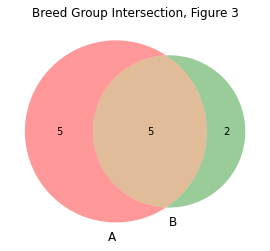

In [99]:
# I think a venn diagram would be useful in conveying this information in my report/presentation
venn = venn2([top_10_extreme, positive_pred])

plt.title('Breed Group Intersection, Figure 3');

In [46]:
# similarity score between two sets! 
similarity_scores = pd.DataFrame({'Description':[], 'Score':[]})
def jaccard_similarity(description, set1, set2):
    global similarity_scores
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity_score = intersection / union 
    new_row = {'Description': description, 'Score': similarity_score}
    similarity_scores = similarity_scores.append(new_row, ignore_index=True)
    return similarity_scores
    
jaccard_similarity('Extreme and Positive', top_10_extreme, positive_pred)
jaccard_similarity('Extreme and Negative', top_10_extreme, negative_pred)
jaccard_similarity('Non and Positive', top_10_non, positive_pred)
jaccard_similarity('Non and Negative', top_10_non, negative_pred)

similarity_scores.sort_values('Score', ascending=False)

,Description,Score
0,Extreme and Positive,0.416667
3,Non and Negative,0.230769
2,Non and Positive,0.214286
1,Extreme and Negative,0.142857


Good! This makes sense. 

#### Neuter Status:
So most of the extreme suckers are neutered, but I feel like most pets that are owned and not feral are neutered. I wonder how the performance would do if I took this feature out in the future. I feel like the proportions aren't that different, but technically there are 12% more neutered kitties in the extreme suckers. 

In [47]:
# (0=intact, 1=neutered)
print(non_suckers['Neuter_status'].value_counts(normalize=True))
print(extreme_suckers['Neuter_status'].value_counts(normalize=True))

1    0.7515
0    0.2485
Name: Neuter_status, dtype: float64
1    0.834906
0    0.165094
Name: Neuter_status, dtype: float64


#### Behavior Problem:

In [48]:
# Does your cat have a behavior problem? 0=I don't know, 1=no, 2=yes, self-diagnosed, 3=yes, diagnosed by a veterinarian.
print(non_suckers['Behaviour_problem'].value_counts(normalize=True))
print(extreme_suckers['Behaviour_problem'].value_counts(normalize=True))

1.0    0.894602
2.0    0.068552
0.0    0.020566
3.0    0.016281
Name: Behaviour_problem, dtype: float64
1.0    0.764151
2.0    0.146226
0.0    0.070755
3.0    0.018868
Name: Behaviour_problem, dtype: float64


Non_suckers are ~8.5% 2's and 3's whereas the extreme suckers are at 26%. Intriguing! Also interesting, non_sucker (human) parents are more confident about their cat not having a behavioral problem than extreme sucker parents as is indicated by the much higher volume of 1's (No) compared to 0's (I don't know). There are also significantly more 2's in the extreme suckers, 22% vs. 6.9%. I wonder if these parents think the wool sucking is a problem?

#### (Excessive) Grooming:

In [49]:
# Grooming (excessive) 1-5, not at all, a little, moderately, a lot, very much
print(non_suckers['Grooming'].value_counts(normalize=True))
print(extreme_suckers['Grooming'].value_counts(normalize=True))

1.0    0.618680
3.0    0.206512
2.0    0.141388
4.0    0.024850
5.0    0.008569
Name: Grooming, dtype: float64
1.0    0.386792
3.0    0.349057
2.0    0.160377
4.0    0.080189
5.0    0.023585
Name: Grooming, dtype: float64


**Excessive Groomers Most Intriguing Proportions:**  
Non-Suckers: 20.7% 3's, 2.5% 4's. **61.9% not at all excessive grooming**   
Extreme suckers: 32.1% 3's, 9% 4's.   **only 38.5% not at all excessive grooming**  
Definitely some higher scores in the extreme suckers.   

In [82]:
# bar graph showing excessive grooming in non suckers as compared to extreme suckers 
# proportion of categories 0-1 for binaries wool_sucking 
# binarize wool_sucking
grooming_binary_extreme = extreme_suckers['Grooming'].replace([1, 2, 3, 4, 5], [0, 1, 1, 1, 1])
grooming_binary_non = non_suckers['Grooming'].replace([1, 2, 3, 4, 5], [0, 1, 1, 1, 1])


groom_dist_bin_ext = grooming_binary_extreme.value_counts(normalize=True)
groom_dist_bin_non = grooming_binary_non.value_counts(normalize=True)

g_ext = [groom_dist_bin_ext[0], groom_dist_bin_ext[1]]
g_non = [groom_dist_bin_non[0], groom_dist_bin_non[1]]

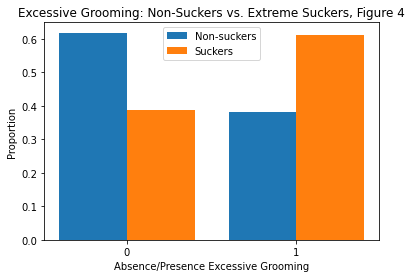

In [100]:
x = np.arange(2)
g_ext = [groom_dist_bin_ext[0], groom_dist_bin_ext[1]]
g_non = [groom_dist_bin_non[0], groom_dist_bin_non[1]]

plt.bar(x - 0.2, g_non, width=0.4, label='Non-suckers')
plt.bar(x + 0.2, g_ext, width=0.4, label='Suckers')

# Adding labels and title
plt.title("Excessive Grooming: Non-Suckers vs. Extreme Suckers, Figure 4")
plt.ylabel('Proportion')
plt.xlabel('Absence/Presence Excessive Grooming')
plt.legend()
plt.xticks([0, 1]);

<div style="background-color: blue; padding: 10px; color: white;">
<h1>8. Conclusion</h1>
<p> What's the final model? Why?</p>
</div>

`LogisticRegression(class_weight='balanced')` will be the final model. This is the simplest model that had comparable performance to the others.

### Interesting Findings: 
* Several Breed groups were at the forefront of the most impactful features in the model, especially BG_RUS (Russian Blue). 
    * {'BG_HCS', 'BG_ORI', 'BG_SBI', 'BG_NFO', 'BG_MCO'} are the overlap of the top 10 most common breed groups for extreme suckers and most positively predicting breed groups (of which there are 7). 
* Neuter status was also towards the top, the proportion of extreme suckers that are neutered is ~10% higher than non suckers. 
* Over 20% more non suckers have no excessive grooming behavior at all. 
* 26% of extreme sucker parents said their kitty had a behavior problem while only 8.5% of non suckers identified the same behavior. 

Paws-itive Predicting Breeds:  
SBI = Saint Birman  
ORI = Balinese, Oriental Longhair, Oriental Shorthair, Seychellois Longhair, Seychellois Shorthair, and Siamese  
NFO = Norwegian Forest Cat  
HCS = House Cat  
MCO = Maine Coone